<a href="https://colab.research.google.com/github/ganeshmp01/DS-Classwork/blob/main/LSTM%26GRU_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
df = pd.read_csv("airline-passengers.csv")

In [3]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [4]:
df.shape

(144, 2)

In [5]:
timeseries = df[['Passengers']].values.astype("float32")

In [6]:
#train-test split
train_size = int(len(timeseries)*0.67)
test_size = len(timeseries) - train_size

In [7]:
train_size

96

In [8]:
test_size

48

In [9]:
train, test = timeseries[:train_size],timeseries[train_size:]

In [11]:
def create_dataset(dataset, lookback):
  """Transform the time series into X and y"""
  X,y = [],[]
  for i in range(len(dataset)- lookback):
    features = dataset[i:i+lookback]
    target = dataset[i+1:i+lookback+1]
    X.append(features)
    y.append(target)
  return torch.tensor(X), torch.tensor(y)

In [12]:
lookback = 4
X_train, y_train = create_dataset(train, lookback = lookback)

<ipython-input-11-08d811c052f7>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


In [14]:
X_test, y_test = create_dataset(test, lookback = lookback)

In [15]:
X_train

tensor([[[112.],
         [118.],
         [132.],
         [129.]],

        [[118.],
         [132.],
         [129.],
         [121.]],

        [[132.],
         [129.],
         [121.],
         [135.]],

        [[129.],
         [121.],
         [135.],
         [148.]],

        [[121.],
         [135.],
         [148.],
         [148.]],

        [[135.],
         [148.],
         [148.],
         [136.]],

        [[148.],
         [148.],
         [136.],
         [119.]],

        [[148.],
         [136.],
         [119.],
         [104.]],

        [[136.],
         [119.],
         [104.],
         [118.]],

        [[119.],
         [104.],
         [118.],
         [115.]],

        [[104.],
         [118.],
         [115.],
         [126.]],

        [[118.],
         [115.],
         [126.],
         [141.]],

        [[115.],
         [126.],
         [141.],
         [135.]],

        [[126.],
         [141.],
         [135.],
         [125.]],

        [[141.],
   

In [62]:
class AirModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.GRU = nn.GRU(input_size = 1, hidden_size = 50, num_layers = 1,batch_first = True)
    self.linear = nn.Linear(50,1)

  def forward(self, x):
    x, _ = self.GRU(x)
    x = self.linear(x)
    return x

In [63]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),batch_size = 10)

In [64]:
%%time
n_epochs = 3000
for epoch in range(n_epochs):
  model.train()
  for X_batch, y_batch in loader:
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #Validation
  if epoch%100!=0:
    continue
  model.eval()
  with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(loss_fn(y_pred,y_train))
    y_pred = model(X_test)
    test_rmse = np.sqrt(loss_fn(y_pred,y_test))
    print("Epoch %d: GRU train RMSE %.4F, GRU test RMSE %.4f"%(epoch,train_rmse,test_rmse))

Epoch 0: GRU train RMSE 225.7444, GRU test RMSE 425.0372
Epoch 100: GRU train RMSE 181.0045, GRU test RMSE 378.1157
Epoch 200: GRU train RMSE 145.4442, GRU test RMSE 339.5472
Epoch 300: GRU train RMSE 116.2593, GRU test RMSE 305.7799
Epoch 400: GRU train RMSE 94.1513, GRU test RMSE 276.7917
Epoch 500: GRU train RMSE 75.9934, GRU test RMSE 250.0405
Epoch 600: GRU train RMSE 61.4324, GRU test RMSE 226.1246
Epoch 700: GRU train RMSE 50.5090, GRU test RMSE 205.1967
Epoch 800: GRU train RMSE 42.1256, GRU test RMSE 186.5409
Epoch 900: GRU train RMSE 36.3319, GRU test RMSE 170.3366
Epoch 1000: GRU train RMSE 32.0119, GRU test RMSE 156.2790
Epoch 1100: GRU train RMSE 28.7586, GRU test RMSE 143.9334
Epoch 1200: GRU train RMSE 26.3742, GRU test RMSE 133.0415
Epoch 1300: GRU train RMSE 24.5723, GRU test RMSE 124.0500
Epoch 1400: GRU train RMSE 23.3808, GRU test RMSE 116.5296
Epoch 1500: GRU train RMSE 23.1228, GRU test RMSE 109.9323
Epoch 1600: GRU train RMSE 22.1181, GRU test RMSE 104.3107
Epoch

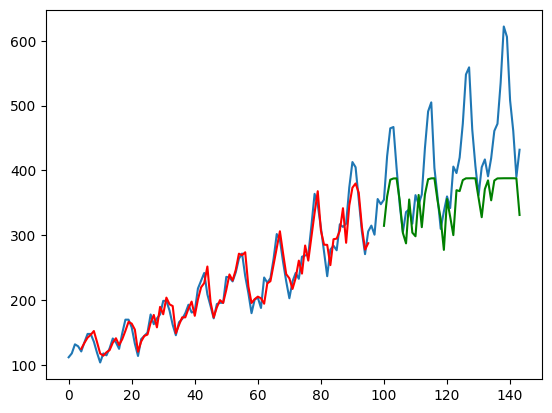

In [65]:
with torch.no_grad():
  #shift the predictions for plotting
  train_plot = np.ones_like(timeseries) * np.nan
  y_pred = model(X_train)
  y_pred = y_pred[:,-1,:]
  train_plot[lookback:train_size] = model(X_train)[:,-1,:]
  #Shift Test Predictions
  test_plot = np.ones_like(timeseries)*np.nan
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:,-1,:]
plt.plot(timeseries)
plt.plot(train_plot,c='r')
plt.plot(test_plot,c = 'g')
plt.show()

In [66]:
class AirModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size = 1, hidden_size = 50, num_layers = 1,batch_first = True)
    self.linear = nn.Linear(50,1)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.linear(x)
    return x

In [67]:
model1 = AirModel1()
optimizer = optim.Adam(model1.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),batch_size = 10)

In [68]:
%%time
n_epochs = 3000
for epoch in range(n_epochs):
  model1.train()
  for X_batch, y_batch in loader:
    y_pred = model1(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #Validation
  if epoch%100!=0:
    continue
  model1.eval()
  with torch.no_grad():
    y_pred = model1(X_train)
    train_rmse = np.sqrt(loss_fn(y_pred,y_train))
    y_pred = model1(X_test)
    test_rmse = np.sqrt(loss_fn(y_pred,y_test))
    print("Epoch %d: LSTM train RMSE %.4F, LSTM test RMSE %.4f"%(epoch,train_rmse,test_rmse))

Epoch 0: LSTM train RMSE 225.8239, LSTM test RMSE 425.0872
Epoch 100: LSTM train RMSE 184.4953, LSTM test RMSE 381.8067
Epoch 200: LSTM train RMSE 153.1752, LSTM test RMSE 348.0023
Epoch 300: LSTM train RMSE 126.5789, LSTM test RMSE 317.7830
Epoch 400: LSTM train RMSE 105.0391, LSTM test RMSE 290.9709
Epoch 500: LSTM train RMSE 88.5281, LSTM test RMSE 267.5538
Epoch 600: LSTM train RMSE 72.5929, LSTM test RMSE 244.0747
Epoch 700: LSTM train RMSE 61.2755, LSTM test RMSE 223.7147
Epoch 800: LSTM train RMSE 52.4634, LSTM test RMSE 205.7260
Epoch 900: LSTM train RMSE 45.3089, LSTM test RMSE 189.4546
Epoch 1000: LSTM train RMSE 39.7146, LSTM test RMSE 174.7660
Epoch 1100: LSTM train RMSE 35.1612, LSTM test RMSE 160.8506
Epoch 1200: LSTM train RMSE 31.6442, LSTM test RMSE 148.3807
Epoch 1300: LSTM train RMSE 28.8543, LSTM test RMSE 137.0323
Epoch 1400: LSTM train RMSE 26.7702, LSTM test RMSE 127.2723
Epoch 1500: LSTM train RMSE 25.1625, LSTM test RMSE 118.5665
Epoch 1600: LSTM train RMSE 24.

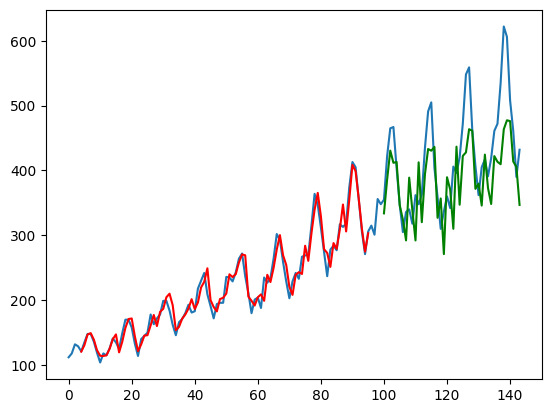

In [69]:
with torch.no_grad():
  #shift the predictions for plotting
  train_plot = np.ones_like(timeseries) * np.nan
  y_pred = model1(X_train)
  y_pred = y_pred[:,-1,:]
  train_plot[lookback:train_size] = model1(X_train)[:,-1,:]
  #Shift Test Predictions
  test_plot = np.ones_like(timeseries)*np.nan
  test_plot[train_size+lookback:len(timeseries)] = model1(X_test)[:,-1,:]
plt.plot(timeseries)
plt.plot(train_plot,c='r')
plt.plot(test_plot,c = 'g')
plt.show()